### TODO::
- Run n iterations and then visualise
- Torus, sphere, klein topologies
- 3D with projection
- Improve the algorithm

### References
https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html

In [523]:
%pylab inline
import numpy as np
import seaborn as sns
from time import time


class SandHeap:
    '''Control class for managaing sandpile topples'''
    patterns = {
            '+': {
                'maxval': 4,
                'topple_cells': [(-1, 0), (1, 0), (0, -1), (0, 1)]
                },
            'x': {
                'maxval': 4,
                'topple_cells': [(-1, 1), (-1, -1), (1, 1), (1, -1)]
                },
            'o': {
                'maxval': 8,
                'topple_cells': [
                    (-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1)
                    ]
                },
            'o+': {
                'maxval': 12,
                'topple_cells': [
                    (-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1),
                    (-1, 0), (1, 0), (0, -1), (0, 1)
                    ]
                },
            'ox': {
                'maxval': 12,
                'topple_cells': [
                    (-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1)
                    ]
                }
        }

    def __init__(self, sand_power=10, topple_pattern='+'):
        self.starting_sand = 2**sand_power

        if topple_pattern in self.patterns:
            self.topple_pattern = topple_pattern
            self.max_per_cell = self.patterns[topple_pattern]['maxval']
            self.topple_cells = self.patterns[topple_pattern]['topple_cells']
        else:
            err = 'Must use one of the following topple patterns: {}'
            raise ValueError(err.format(', '.join(self.max_heap_size.keys())))

        self.init_grid()

    def init_grid(self):
        side_length = int(self.starting_sand ** 0.5)
        if self.topple_pattern == 'x':
            side_length = int(side_length * 1.1)
        else:
            side_length *= 0.6

        self.grid = np.zeros((side_length, side_length), np.int64)
        centre = int(side_length / 2)
        self.grid[centre][centre] = self.starting_sand
        print("Grid initialised:\nside-length {}\ninitial sand {}".format(side_length, self.starting_sand))

    def topple(self, verbose=False):
        '''Topple the sand in the grid until we reach a steady state'''
        start = time()
        passes = 0

        while np.max(self.grid) >= self.max_per_cell:
            for rowix, row in enumerate(self.grid):
                if np.max(row) >= self.max_per_cell:
                    for cellix, cell in enumerate(row):
                        if cell >= self.max_per_cell:
                            self.topple_cell(rowix, cellix)
            print(".", end="")
            passes += 1

        if verbose:
            t = time() - start
            print("\n{} passes required".format(passes))
            print("{}s to reach stable state".format(t))
        self.trim_grid()
    
    def ntopple(self, n, verbose=False):
        '''Topple the sand in the grid for n iterations or until we reach a steady state'''
        start = time()
        passes = 0

        for _ in range(n):
            for rowix, row in enumerate(self.grid):
                if np.max(row) >= self.max_per_cell:
                    for cellix, cell in enumerate(row):
                        if cell >= self.max_per_cell:
                            self.topple_cell(rowix, cellix)
            print(".", end="")
            passes += 1
            # Break if we're at steady state
            if np.max(self.grid) < self.max_per_cell:
                break

        return self.trim_grid(copy=True)

    def topple_cell(self, row, col):
        '''Distribute sand to neighbouring cells'''
        n, rem = divmod(self.grid[row][col], self.max_per_cell)
        self.grid[row][col] = rem
        for trow, tcol in self.topple_cells:
            self.grid[row + trow][col + tcol] += n

    def trim_grid(self, copy=False):
        grid = np.copy(self.grid) if copy else self.grid

        # Trim empty
        grid = [r for r in grid if sum(r) > 0]
        # Trim empty columns
        w1 = len(grid[0])
        trans = [[r[n] for r in grid] for n in range(w1)]
        trans = [r for r in trans if sum(r) > 0]
        w2 = len(trans[0])
        grid = [[r[n] for r in trans] for n in range(w2)]
        
        if copy:
            return grid
        else:
            self.grid = grid
            

    def print_grid(self):
        print(s.starting_sand)
        for row in self.grid:
            line = [str(cell) for cell in row]
            print(''.join(line))

Populating the interactive namespace from numpy and matplotlib


In [ ]:
res = {
    20: {
        "sideLength": 1025,
        "initialSand": 1048576,
        "results": {
            "o": {
                "passes": 37891,
                "runTime": 15044.06
            }
        }
    }
}

Grid initialised:
side-length 76.8
initial sand 16384
..........

/home/innes/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


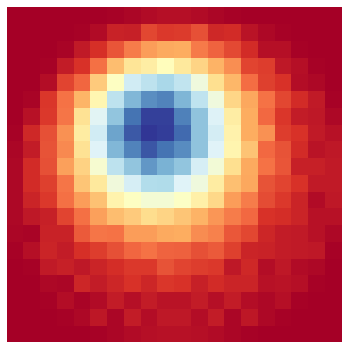

In [681]:
s = SandHeap(14, 'o+')
g = s.ntopple(10, True)
plt.figure(figsize=(6, 6))
sns.heatmap(g, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

.

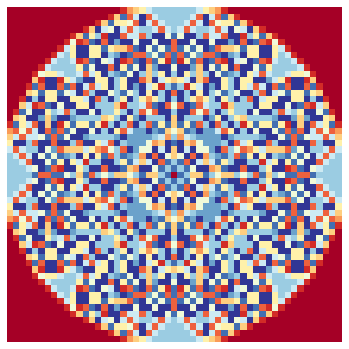

In [720]:
g = s.ntopple(10, True)
plt.figure(figsize=(6, 6))
sns.heatmap(g, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

/home/innes/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Grid initialised:
side-length 76.8
initial sand 16384
......................................................................................................................................................................................................................................................................................................................................................................................

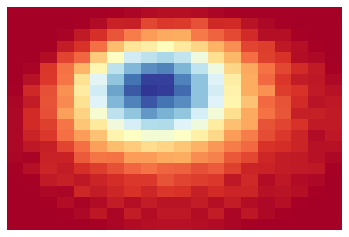

In [754]:
from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()
#ax = plt.axes()

s = SandHeap(14, 'o+')
g = s.ntopple(10, True)
ax = sns.heatmap(g, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

def init():
    ax = sns.heatmap(g, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")
    return ax,

def animate(i, ax, fig):
    ax.cla()
    g = s.ntopple(10, True)
    ax = sns.heatmap(g, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu", ax=ax)
    return ax,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=40, interval=100, fargs=(ax,fig))
anim.save('2_14_o+.mp4', writer='ffmpeg',bitrate=2000)
plt.show()

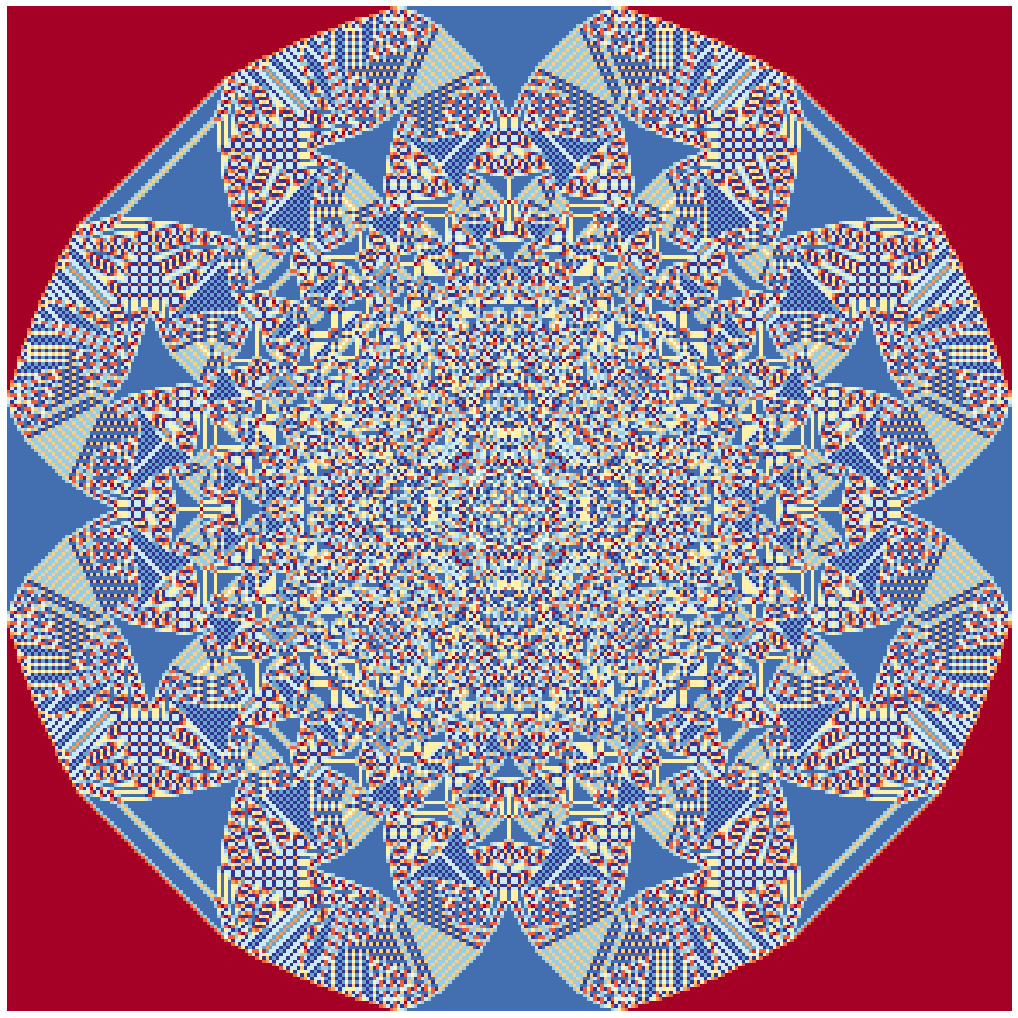

In [221]:
plt.figure(figsize=(18, 18))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

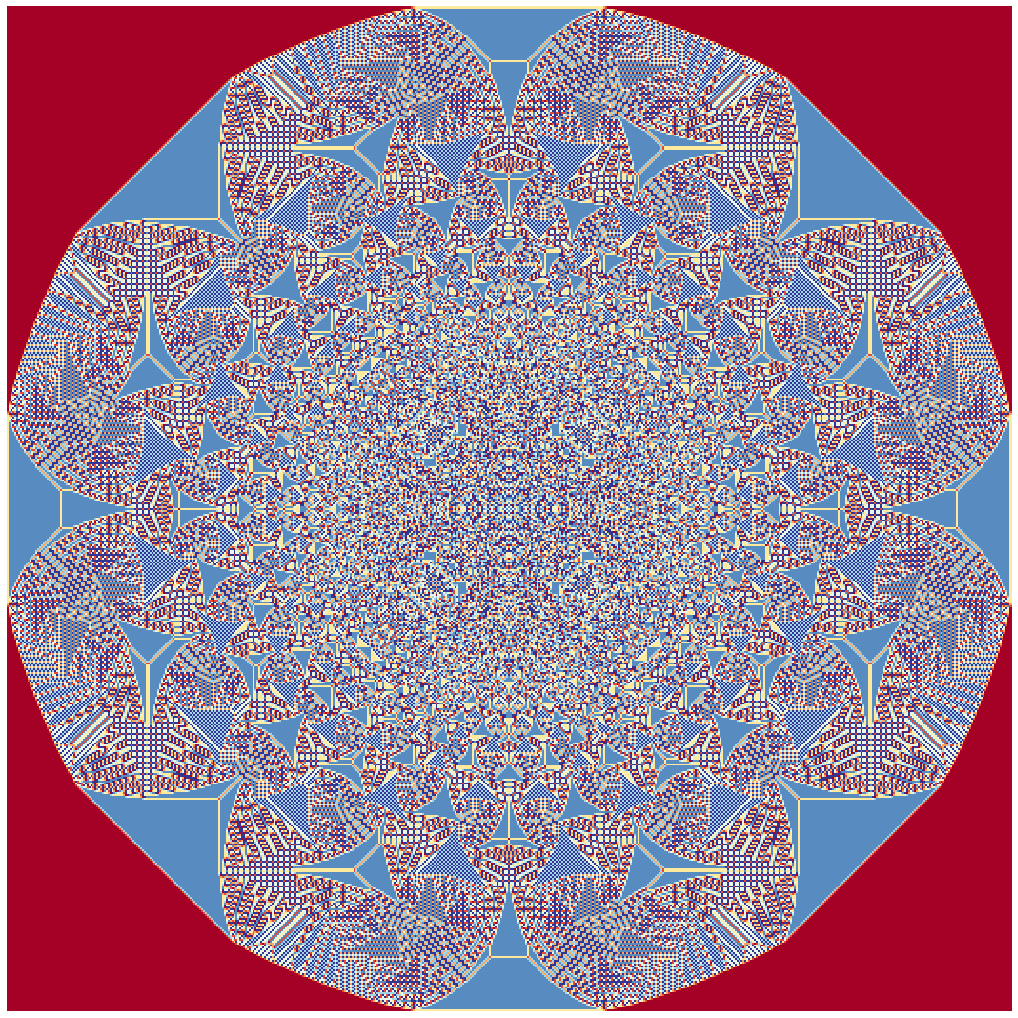

In [21]:
plt.figure(figsize=(18, 18))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

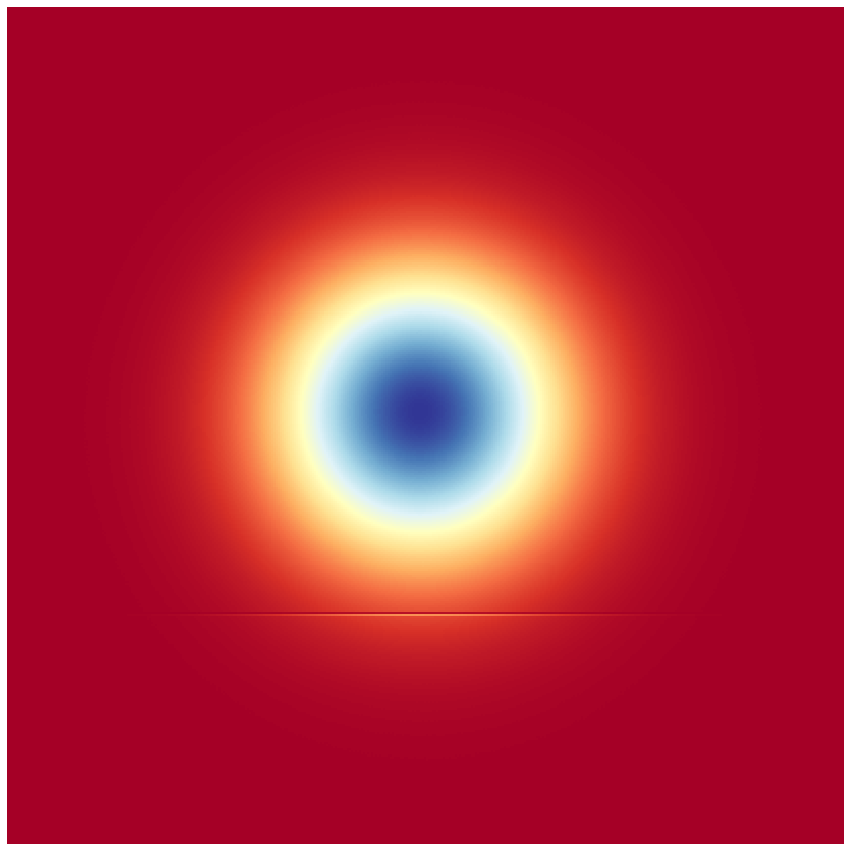

In [17]:
s.trim_grid()
plt.figure(figsize=(15, 15))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")